In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
smiley = pd.read_csv('smiley.csv', index_col = 0)
smiley.columns = ['x', 'y', 'classes']

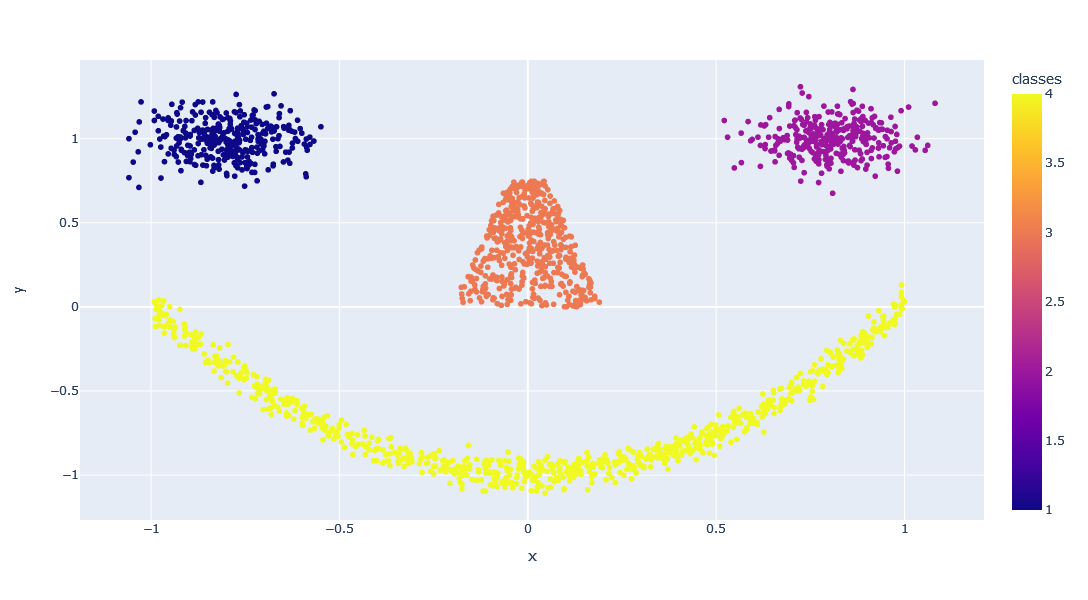

In [3]:
fig = px.scatter(smiley, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [4]:
# Sampling from each individual column then append together
# Function: can take categorical input sampling when it is NOT one-hot encoded
def sampling(data, n, random_state):
    synth_data = pd.DataFrame()
    i = 0
    # sample column by column
    # pseudo-random
    for column in data.columns:
        synth_data[column] = data[column].sample(n = n, replace = True, random_state = random_state + i * 10).reset_index(drop = True)
        i += 1
    return synth_data

In [5]:
synth_smiley = sampling(smiley, 2000, 111)

In [6]:
# encode features, run once only
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)
smiley_targets_enc = enc.fit_transform(smiley[['classes']])
enc = OneHotEncoder(sparse = False)
synths_targets_enc = enc.fit_transform(synth_smiley[['classes']])

Feasibly can adapt to any dataset, but need a way to read in categorical variables
 - Specify columns that are categorical

In [7]:
smiley[['0', '1', '2', '3']] = smiley_targets_enc
smiley.drop(['classes'], axis = 1, inplace = True)
synth_smiley[['0', '1', '2', '3']] = synths_targets_enc
synth_smiley.drop(['classes'], axis = 1, inplace = True)

In [8]:
smiley['label'] = 1
synth_smiley['label'] = 0
X = pd.concat((smiley, synth_smiley))
X = X.reset_index().drop('index', axis = 1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [10]:
import xgboost as xgb

In [11]:
model = xgb.XGBClassifier(random_state = 1, n_estimators = 50, max_depth = 2, learning_rate = 1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [12]:
preds = model.predict(X_test)
np.sum(preds == y_test)/len(y_test)
model.score(X_test, y_test)

0.9175

In [13]:
booster = model.get_booster()

In [14]:
#get all real datapoints
indices = y_train[y_train == 1].index
real_df = X_train.loc[indices].reset_index().drop('index', axis = 1)

In [15]:
leaves = booster.predict(xgb.DMatrix(real_df), pred_leaf = True)
contribs = booster.predict(xgb.DMatrix(real_df), pred_contribs = True, strict_shape = True)

In [16]:
booster.dump_model('xgb_model.txt', with_stats = True)

In [17]:
# get df of trees information
tree_df = booster.trees_to_dataframe()

In [18]:
# split into each idv tree
trees_grouped = tree_df.groupby('Tree')
trees = [trees_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in trees_grouped.groups]

In [19]:
upper_bounds = []
lower_bounds = []

In [20]:
#get bounds for all leaves of all trees
columns = ['x', 'y', '0', '1', '2', '3']
for tree in trees:
    size = len(tree)
    upper_df = pd.DataFrame(np.ones((size, 6)) * np.inf, columns = columns)
    lower_df = pd.DataFrame(np.ones((size, 6)) * -np.inf, columns = columns)
    non_leaves = []
    for index, row in tree.iterrows():
        left_child = row['Yes']
        right_child = row['No']
        feature = row['Feature']
        split = row['Split']
        parent = int(row['Node'])
        if feature != 'Leaf':
            parent_lower = lower_df.loc[parent]
            parent_upper = upper_df.loc[parent]
            left_child = int(left_child.split('-')[1])
            right_child = int(right_child.split('-')[1])
            lower_df.loc[left_child] = parent_lower
            lower_df.loc[right_child] = parent_lower
            upper_df.loc[left_child] = parent_upper
            upper_df.loc[right_child] = parent_upper
            upper_df.loc[left_child, feature] = split
            lower_df.loc[right_child, feature] = split
            non_leaves.append(parent)
    upper_df = upper_df.drop(non_leaves)
    lower_df = lower_df.drop(non_leaves)
    upper_bounds.append(upper_df)
    lower_bounds.append(lower_df)

In [21]:
leaves_df = pd.DataFrame(leaves)

In [22]:
from sklearn.cluster import AgglomerativeClustering
import scipy.spatial.distance

In [23]:
clustering = AgglomerativeClustering(n_clusters = None, affinity = 'hamming', linkage = 'average', distance_threshold = 0.05)
clustering.fit(leaves)

AgglomerativeClustering(affinity='hamming', distance_threshold=0.05,
                        linkage='average', n_clusters=None)

In [24]:
leaves_df['cluster'] = clustering.labels_

In [25]:
counts = leaves_df.groupby('cluster').count()[0]
valid_clusters = counts[counts > 3].index
clusters = []
coverage = []
for cluster_id in valid_clusters:
    cluster = leaves_df[leaves_df['cluster'] == cluster_id]
    cluster_size = len(cluster)
    cluster_centroid = cluster.mode().iloc[0]
    clusters.append(cluster_centroid)
    coverage.append(cluster_size)

In [26]:
len(clusters)

51

In [27]:
upper_cluster_bounds = []
lower_cluster_bounds = []
for i in range(0, len(clusters)):
    uppers = []
    lowers = []
    for j in range(0, len(upper_bounds)):
        uppers.append(upper_bounds[j].loc[clusters[i][j]])
        lowers.append(lower_bounds[j].loc[clusters[i][j]])
    upper_cluster_bounds.append(pd.DataFrame(uppers).min(axis = 0))
    lower_cluster_bounds.append(pd.DataFrame(lowers).max(axis = 0))
upper_cluster_bounds = pd.DataFrame(upper_cluster_bounds)
lower_cluster_bounds = pd.DataFrame(lower_cluster_bounds)

In [28]:
upper_cluster_bounds.columns = upper_cluster_bounds.columns + ' upper'
lower_cluster_bounds.columns = lower_cluster_bounds.columns + ' lower'

In [29]:
final_bounds = pd.concat([upper_cluster_bounds, lower_cluster_bounds], axis = 1)

In [30]:
n = sum(coverage)
fractions = [coverage[i]/n for i in range(0, len(coverage))]

In [31]:
sample = final_bounds.sample(2000, weights = fractions, replace = True)

In [32]:
sample_data = []
for index, row in sample.iterrows():
    x = (row['x upper'] - row['x lower']) * np.random.random_sample() + row['x lower']
    y = (row['y upper'] - row['y lower']) * np.random.random_sample() + row['y lower']
    if row['0 upper'] == np.inf and row['0 lower'] == 0.5:
        label = 0
    elif row['1 upper'] == np.inf and row['1 lower'] == 0.5:
        label = 1
    elif row['2 upper'] == np.inf and row['2 lower'] == 0.5:
        label = 2
    else:
        label = 3
    sample_data.append([x, y, label])
gen = pd.DataFrame(sample_data)
gen.columns = ['x', 'y', 'classes']

/tmp/ipykernel_98/3648666551.py:3: RuntimeWarning:

invalid value encountered in double_scalars

/tmp/ipykernel_98/3648666551.py:4: RuntimeWarning:

invalid value encountered in double_scalars



In [33]:
gen

x         y  classes
0    -0.061642 -1.024838        3
1     0.056195  0.538283        2
2     0.017087  0.119997        2
3    -0.300813 -0.923385        3
4    -0.126750  0.219732        2
...        ...       ...      ...
1995  0.381099 -0.793567        3
1996 -0.020980  0.138165        2
1997  0.047681  0.564702        2
1998  0.065754  0.154424        2
1999  0.736794 -0.497994        3

[2000 rows x 3 columns]

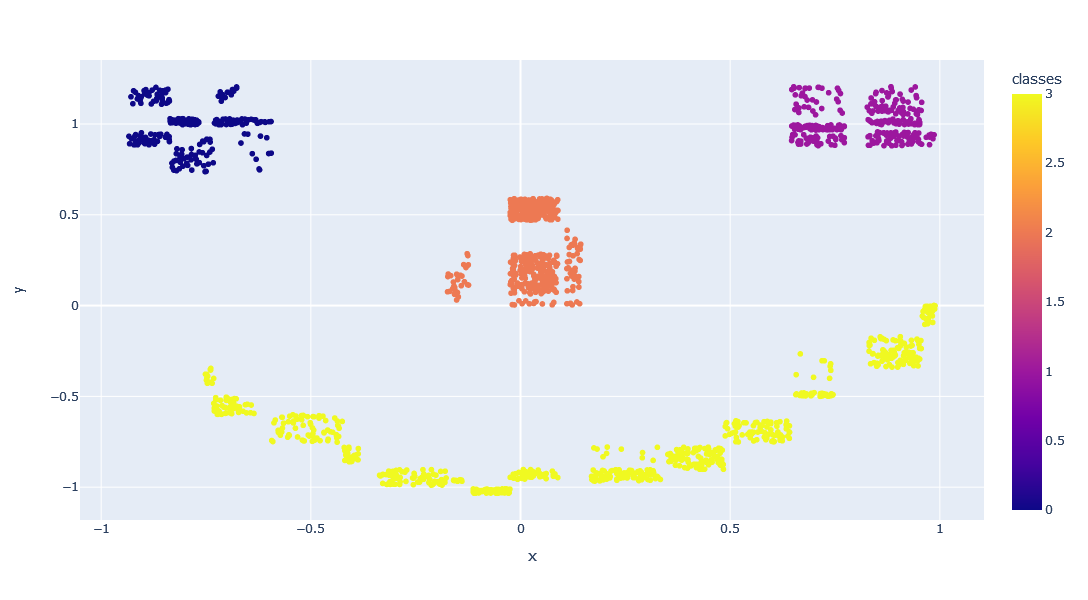

In [34]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

## Density Estimation with clusters

In [35]:
real_df

x         y    0    1    2    3
0    -0.836145  0.807116  1.0  0.0  0.0  0.0
1    -0.941679 -0.086698  0.0  0.0  0.0  1.0
2     0.709411  1.110365  0.0  1.0  0.0  0.0
3    -0.966649  0.035358  0.0  0.0  0.0  1.0
4     0.101098  0.086843  0.0  0.0  1.0  0.0
...        ...       ...  ...  ...  ...  ...
1426 -0.749943  0.933628  1.0  0.0  0.0  0.0
1427 -0.064748  0.675677  0.0  0.0  1.0  0.0
1428 -0.698480  0.909858  1.0  0.0  0.0  0.0
1429 -0.560815 -0.669808  0.0  0.0  0.0  1.0
1430 -0.639596 -0.649187  0.0  0.0  0.0  1.0

[1431 rows x 6 columns]

In [36]:
cluster_df = real_df
cluster_df['clusters'] = clustering.labels_
cluster_df = cluster_df[cluster_df['clusters'].isin(valid_clusters)]
cluster_grouped = cluster_df.groupby('clusters')
cluster_dfs = [cluster_grouped.get_group(x).reset_index().drop('index', axis = 1) for x in cluster_grouped.groups]

In [37]:
from sklearn.neighbors import KernelDensity

In [38]:
densities = []
multinomial = [[] for i in range(len(valid_clusters))]
for i in range(0, len(cluster_dfs)):
    densities.append(KernelDensity(kernel = 'gaussian', bandwidth = 0.05).fit(cluster_dfs[i].iloc[:, :2]))
    cluster_size = len(cluster_dfs[i])
    for j in range(0, 4):
        # laplacian estimation
        multinomial[i].append((sum(cluster_dfs[i].iloc[:, 2 + j]) + 1)/(cluster_size + 4))

In [39]:
samples = []
sample_size = 2000
forest_size = 100
class_size = 4
samples_class = []
for i in range(sample_size):
    cluster_index = np.random.choice(len(valid_clusters), p = fractions)
    sampler = densities[cluster_index]
    class_label = np.random.choice(class_size, p = multinomial[cluster_index])
    samples.append(sampler.sample())
    samples_class.append(class_label)
len(samples)

2000

In [40]:
gen = pd.DataFrame(np.array(samples).reshape((2000, 2)))
gen['classes'] = samples_class
gen.columns = ['x', 'y', 'classes']

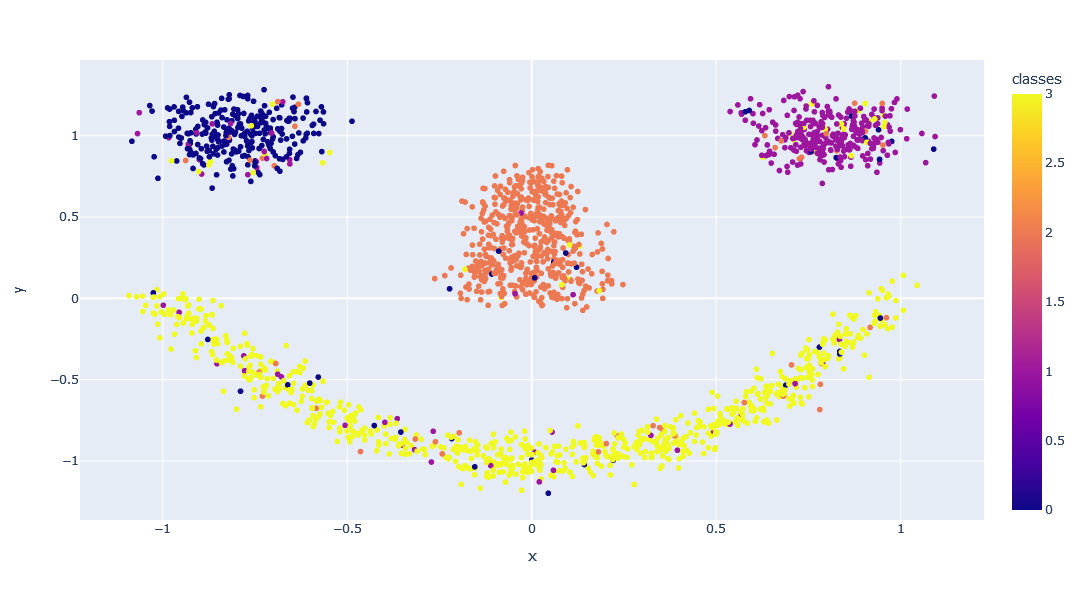

In [41]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

## Uniform Box Sampling with Bound Expansion

In [42]:
leaves_df

0    1    2    3    4    5    6    7    8    9  ...   41   42   43  \
0     5.0  3.0  5.0  4.0  5.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1     5.0  3.0  6.0  3.0  5.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  5.0  4.0   
2     6.0  4.0  5.0  4.0  6.0  5.0  4.0  5.0  6.0  5.0  ...  6.0  6.0  6.0   
3     5.0  3.0  6.0  4.0  5.0  3.0  3.0  3.0  3.0  6.0  ...  3.0  5.0  4.0   
4     5.0  3.0  5.0  4.0  6.0  3.0  6.0  5.0  3.0  5.0  ...  6.0  5.0  6.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1426  5.0  3.0  5.0  4.0  5.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1427  5.0  3.0  5.0  4.0  6.0  3.0  6.0  5.0  3.0  5.0  ...  6.0  5.0  6.0   
1428  5.0  3.0  5.0  4.0  6.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1429  5.0  3.0  4.0  3.0  4.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  4.0  4.0   
1430  5.0  3.0  4.0  3.0  4.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  3.0  4.0   

       44   45   46   47   48   49  cluster  
0     5.0  4.0  3.0  4.0  3.0  4.0       34  
1     5.0  4.0  3.0  4.0  3.0  3.0        4  
2     6.0  6.0  4.0  6.0  6.0  4.0       28  
3     5.0  4.0  3.0  4.0  3.0  3.0       32  
4     6.0  6.0  5.0  6.0  3.0  3.0       38  
...   ...  ...  ...  ...  ...  ...      ...  
1426  5.0  4.0  3.0  4.0  3.0  4.0       47  
1427  6.0  6.0  5.0  6.0  3.0  4.0       20  
1428  5.0  4.0  3.0  4.0  3.0  4.0       47  
1429  4.0  6.0  3.0  3.0  3.0  3.0       45  
1430  4.0  4.0  3.0  3.0  3.0  3.0       45  

[1431 rows x 51 columns]

In [43]:
leaves_df = leaves_df[leaves_df['cluster'].isin(valid_clusters)]
leaves_grouped = leaves_df.groupby('cluster')
leaves_dfs = [leaves_grouped.get_group(x).reset_index().drop('index', axis = 1).drop_duplicates() for x in leaves_grouped.groups]

In [44]:
upper_box_df = []
lower_box_df = []
for i in range(0, len(leaves_dfs)):
    upper_box = []
    lower_box = []
    working_df = leaves_dfs[i]
    for index, row in working_df.iterrows():
        uppers = []
        lowers = []
        for k in range(0, len(upper_bounds)):
            leaf_value = row[k]
            uppers.append(upper_bounds[k].loc[leaf_value])
            lowers.append(lower_bounds[k].loc[leaf_value])
        upper_box.append(pd.DataFrame(uppers).min(axis = 0))
        lower_box.append(pd.DataFrame(lowers).max(axis = 0))
    upper_box_df.append(pd.DataFrame(upper_box).max(axis = 0))
    lower_box_df.append(pd.DataFrame(lower_box).min(axis = 0))
upper_box_df = pd.DataFrame(upper_box_df)
lower_box_df = pd.DataFrame(lower_box_df)

In [45]:
working_df

0    1    2    3    4    5    6    7    8    9  ...   41   42   43   44  \
0  5.0  3.0  4.0  3.0  4.0  3.0  3.0  5.0  3.0  4.0  ...  6.0  4.0  5.0  4.0   

    45   46   47   48   49  cluster  
0  5.0  3.0  6.0  3.0  3.0       63  

[1 rows x 51 columns]

In [46]:
upper_box_df.columns = upper_box_df.columns + ' upper'
lower_box_df.columns = lower_box_df.columns + ' lower'

In [47]:
final_box = pd.concat([upper_box_df, lower_box_df], axis = 1)

In [48]:
n = sum(coverage)
fractions = [coverage[i]/n for i in range(0, len(coverage))]

In [49]:
sample = final_box.sample(2000, weights = fractions, replace = True)

In [50]:
sample_data = []
for index, row in sample.iterrows():
    x = (row['x upper'] - row['x lower']) * np.random.random_sample() + row['x lower']
    y = (row['y upper'] - row['y lower']) * np.random.random_sample() + row['y lower']
    if row['0 upper'] == np.inf and row['0 lower'] == 0.5:
        label = 0
    elif row['1 upper'] == np.inf and row['1 lower'] == 0.5:
        label = 1
    elif row['2 upper'] == np.inf and row['2 lower'] == 0.5:
        label = 2
    else:
        label = 3
    sample_data.append([x, y, label])
gen = pd.DataFrame(sample_data)
gen.columns = ['x', 'y', 'classes']

/tmp/ipykernel_98/3648666551.py:3: RuntimeWarning:

invalid value encountered in double_scalars

/tmp/ipykernel_98/3648666551.py:4: RuntimeWarning:

invalid value encountered in double_scalars



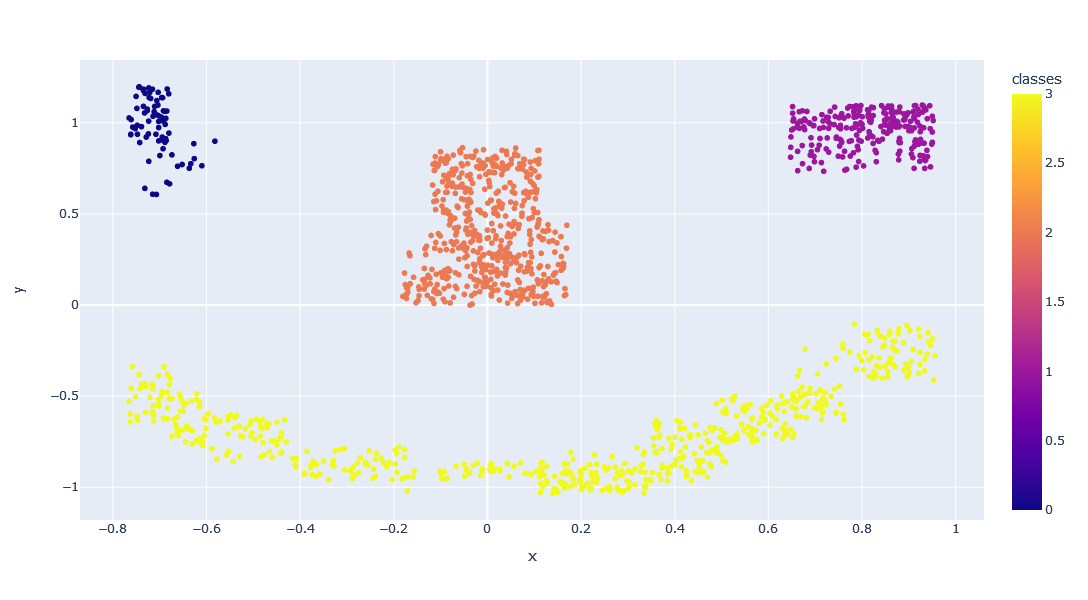

In [51]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [52]:
final_box.head()

x upper   y upper  0 upper  1 upper  2 upper  3 upper   x lower   y lower  \
0 -0.566746       inf      inf      0.5      0.5      0.5 -0.676799  0.965872   
1 -0.138887  0.286087      0.5      0.5      inf      0.5 -0.181764  0.000765   
2  0.110101 -0.958773      0.5      0.5      0.5      inf -0.138887      -inf   
3  0.956953  0.946288      0.5      inf      0.5      0.5  0.783657  0.747301   
4 -0.766309  0.027213      0.5      0.5      0.5      inf      -inf -0.432803   

   0 lower  1 lower  2 lower  3 lower  
0      0.5     -inf     -inf     -inf  
1     -inf     -inf      0.5     -inf  
2     -inf     -inf     -inf      0.5  
3     -inf      0.5     -inf     -inf  
4     -inf     -inf     -inf      0.5

In [53]:
final_bounds.head()

x upper   y upper  0 upper  1 upper  2 upper  3 upper   x lower   y lower  \
0 -0.593845  1.029470      inf      0.5      0.5      0.5 -0.676799  0.995497   
1 -0.138887  0.181359      0.5      0.5      inf      0.5 -0.174791  0.030096   
2 -0.024650 -1.009431      0.5      0.5      0.5      inf -0.121373 -1.033991   
3  0.956953  0.946288      0.5      inf      0.5      0.5  0.826805  0.877101   
4 -0.934152 -0.171138      0.5      0.5      0.5      inf      -inf -0.203971   

   0 lower  1 lower  2 lower  3 lower  
0      0.5     -inf     -inf     -inf  
1     -inf     -inf      0.5     -inf  
2     -inf     -inf     -inf      0.5  
3     -inf      0.5     -inf     -inf  
4     -inf     -inf     -inf      0.5

## MLE with clusters

In [54]:
np.array(cluster_dfs[17].iloc[:, :2].min())

array([-0.75168043,  0.71788256])

In [55]:
from scipy.stats import multivariate_normal

In [56]:
mean = []
cov = []
min_value = []
max_value = []
multinomial = [[] for i in range(len(valid_clusters))]
for i in range(0, len(cluster_dfs)):
    working_df = cluster_dfs[i]
    mean.append(working_df.iloc[:, :2].mean())
    cov.append(working_df.iloc[:, :2].cov())
    min_value.append(working_df.iloc[:, :2].min())
    max_value.append(working_df.iloc[:, :2].max())
    cluster_size = len(cluster_dfs[i])
    for j in range(0, 4):
        # laplacian estimation
        multinomial[i].append((sum(cluster_dfs[i].iloc[:, 2 + j]) + 0.1)/(cluster_size + 0.4))

In [57]:
samples = []
sample_size = 2000
forest_size = 100
class_size = 4
samples_class = []
for i in range(sample_size):
    cluster_index = np.random.choice(len(valid_clusters), p = fractions)
    sample_mean = mean[cluster_index]
    sample_cov = cov[cluster_index]
    # rejection sampling
    sample_min = min_value[cluster_index]
    sample_max = max_value[cluster_index]
    class_label = np.random.choice(class_size, p = multinomial[cluster_index])
    k = multivariate_normal.pdf(x = sample_mean, mean = sample_mean, cov = sample_cov)
    x = np.random.uniform(low = sample_min, high = sample_max, size = (1, 2))
    y = np.random.uniform(low = 0, high = k, size = 1)
    while y > multivariate_normal.pdf(x = x, mean = sample_mean, cov = sample_cov):
        x = np.random.uniform(low = sample_min, high = sample_max, size = (1, 2))
        y = np.random.uniform(low = 0, high = k, size = 1)
    samples.append(x)
    samples_class.append(class_label)
len(samples)

2000

In [58]:
gen = pd.DataFrame(np.array(samples).reshape((2000, 2)))
gen['classes'] = samples_class
gen.columns = ['x', 'y', 'classes']

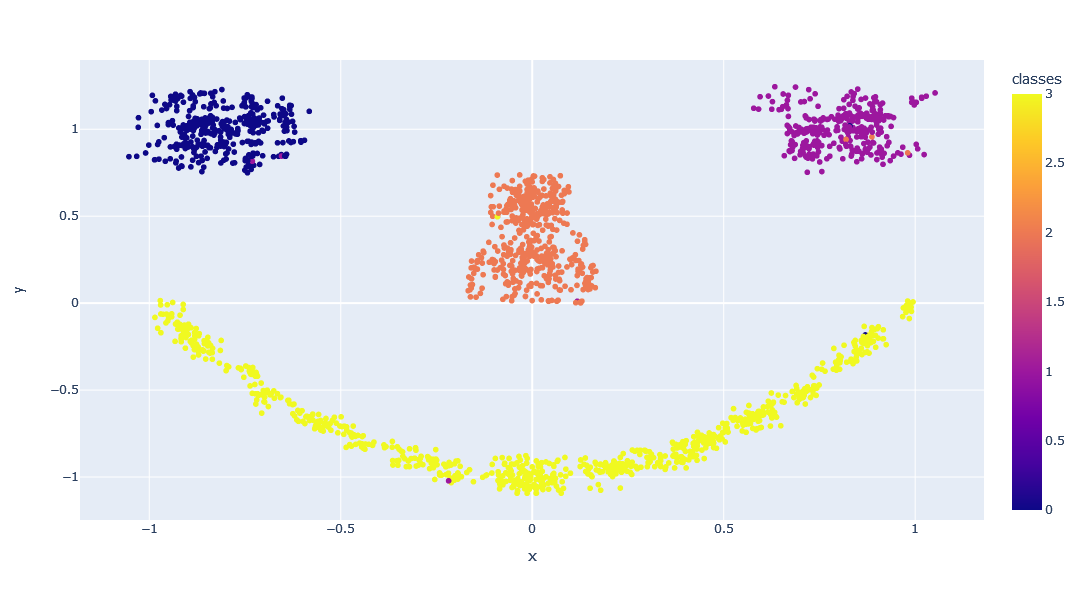

In [59]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [60]:
trees[0]

Tree  Node   ID Feature     Split  Yes   No Missing       Gain   Cover  \
0     0     0  0-0       y -1.033991  0-1  0-2     0-1   4.619208  700.00   
1     0     1  0-1       3  0.500000  0-3  0-4     0-3  23.303595   12.75   
2     0     2  0-2       y  0.995497  0-5  0-6     0-5   2.868409  687.25   
3     0     3  0-3    Leaf       NaN  NaN  NaN     NaN  -1.500000    3.00   
4     0     4  0-4    Leaf       NaN  NaN  NaN     NaN   1.348837    9.75   
5     0     5  0-5    Leaf       NaN  NaN  NaN     NaN   0.002647  565.75   
6     0     6  0-6    Leaf       NaN  NaN  NaN     NaN   0.171429  121.50   

   Category  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  
6       NaN

In [61]:
import networkx as nx

In [62]:
g = nx.Graph()
leaves = []
for index, row in trees[0].iterrows():
    parent = int(row['Node'])
    feature = row['Feature']
    if feature != 'Leaf':
        left_child = int(row['Yes'].split('-')[1])
        right_child = int(row['No'].split('-')[1])
        g.add_edge(parent, left_child)
        g.add_edge(parent, right_child)
    else: 
        leaves.append(parent)

In [63]:
leaves

[3, 4, 5, 6]

In [64]:
g.edges()

EdgeView([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6)])

In [65]:
distance_list = {}
for i in range(len(leaves)):
    for j in range(len(leaves)):
        source = leaves[i]
        target = leaves[j]
        distance = nx.shortest_path_length(g, source=source, target=target, weight=None, method='dijkstra')
        distance_list[source, target] = distance

In [66]:
leaves_df

0    1    2    3    4    5    6    7    8    9  ...   41   42   43  \
0     5.0  3.0  5.0  4.0  5.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1     5.0  3.0  6.0  3.0  5.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  5.0  4.0   
2     6.0  4.0  5.0  4.0  6.0  5.0  4.0  5.0  6.0  5.0  ...  6.0  6.0  6.0   
4     5.0  3.0  5.0  4.0  6.0  3.0  6.0  5.0  3.0  5.0  ...  6.0  5.0  6.0   
5     5.0  3.0  4.0  3.0  4.0  3.0  4.0  5.0  4.0  4.0  ...  6.0  4.0  5.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1426  5.0  3.0  5.0  4.0  5.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1427  5.0  3.0  5.0  4.0  6.0  3.0  6.0  5.0  3.0  5.0  ...  6.0  5.0  6.0   
1428  5.0  3.0  5.0  4.0  6.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1429  5.0  3.0  4.0  3.0  4.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  4.0  4.0   
1430  5.0  3.0  4.0  3.0  4.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  3.0  4.0   

       44   45   46   47   48   49  cluster  
0     5.0  4.0  3.0  4.0  3.0  4.0       34  
1     5.0  4.0  3.0  4.0  3.0  3.0        4  
2     6.0  6.0  4.0  6.0  6.0  4.0       28  
4     6.0  6.0  5.0  6.0  3.0  3.0       38  
5     4.0  6.0  4.0  6.0  4.0  3.0       11  
...   ...  ...  ...  ...  ...  ...      ...  
1426  5.0  4.0  3.0  4.0  3.0  4.0       47  
1427  6.0  6.0  5.0  6.0  3.0  4.0       20  
1428  5.0  4.0  3.0  4.0  3.0  4.0       47  
1429  4.0  6.0  3.0  3.0  3.0  3.0       45  
1430  4.0  4.0  3.0  3.0  3.0  3.0       45  

[1403 rows x 51 columns]

In [67]:
leaves_df[0]

0       5.0
1       5.0
2       6.0
4       5.0
5       5.0
       ... 
1426    5.0
1427    5.0
1428    5.0
1429    5.0
1430    5.0
Name: 0, Length: 1403, dtype: float32

In [68]:
distance_matrix = []
for i in range(len(leaves_df)):
    row = []
    for j in range(len(leaves_df)):
        row.append(distance_list[leaves_df.iloc[i, 0], leaves_df.iloc[j, 0]])
    distance_matrix.append(row)
distance_matrix = np.asarray(distance_matrix)
distance_matrix

array([[0, 0, 2, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [2, 2, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0]])

In [69]:
#get bounds for all leaves of all trees
columns = ['x', 'y', '0', '1', '2', '3']
for tree in trees:
    size = len(tree)
    upper_df = pd.DataFrame(np.ones((size, 6)) * np.inf, columns = columns)
    lower_df = pd.DataFrame(np.ones((size, 6)) * -np.inf, columns = columns)
    non_leaves = []
    for index, row in tree.iterrows():
        left_child = row['Yes']
        right_child = row['No']
        feature = row['Feature']
        split = row['Split']
        parent = int(row['Node'])
        if feature != 'Leaf':
            parent_lower = lower_df.loc[parent]
            parent_upper = upper_df.loc[parent]
            left_child = int(left_child.split('-')[1])
            right_child = int(right_child.split('-')[1])
            lower_df.loc[left_child] = parent_lower
            lower_df.loc[right_child] = parent_lower
            upper_df.loc[left_child] = parent_upper
            upper_df.loc[right_child] = parent_upper
            upper_df.loc[left_child, feature] = split
            lower_df.loc[right_child, feature] = split
            non_leaves.append(parent)
    upper_df = upper_df.drop(non_leaves)
    lower_df = lower_df.drop(non_leaves)
    upper_bounds.append(upper_df)
    lower_bounds.append(lower_df)

In [70]:
leaves_df

0    1    2    3    4    5    6    7    8    9  ...   41   42   43  \
0     5.0  3.0  5.0  4.0  5.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1     5.0  3.0  6.0  3.0  5.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  5.0  4.0   
2     6.0  4.0  5.0  4.0  6.0  5.0  4.0  5.0  6.0  5.0  ...  6.0  6.0  6.0   
4     5.0  3.0  5.0  4.0  6.0  3.0  6.0  5.0  3.0  5.0  ...  6.0  5.0  6.0   
5     5.0  3.0  4.0  3.0  4.0  3.0  4.0  5.0  4.0  4.0  ...  6.0  4.0  5.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1426  5.0  3.0  5.0  4.0  5.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1427  5.0  3.0  5.0  4.0  6.0  3.0  6.0  5.0  3.0  5.0  ...  6.0  5.0  6.0   
1428  5.0  3.0  5.0  4.0  6.0  5.0  3.0  3.0  3.0  5.0  ...  4.0  5.0  4.0   
1429  5.0  3.0  4.0  3.0  4.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  4.0  4.0   
1430  5.0  3.0  4.0  3.0  4.0  3.0  3.0  3.0  3.0  4.0  ...  3.0  3.0  4.0   

       44   45   46   47   48   49  cluster  
0     5.0  4.0  3.0  4.0  3.0  4.0       34  
1     5.0  4.0  3.0  4.0  3.0  3.0        4  
2     6.0  6.0  4.0  6.0  6.0  4.0       28  
4     6.0  6.0  5.0  6.0  3.0  3.0       38  
5     4.0  6.0  4.0  6.0  4.0  3.0       11  
...   ...  ...  ...  ...  ...  ...      ...  
1426  5.0  4.0  3.0  4.0  3.0  4.0       47  
1427  6.0  6.0  5.0  6.0  3.0  4.0       20  
1428  5.0  4.0  3.0  4.0  3.0  4.0       47  
1429  4.0  6.0  3.0  3.0  3.0  3.0       45  
1430  4.0  4.0  3.0  3.0  3.0  3.0       45  

[1403 rows x 51 columns]

In [71]:
tree_df


Tree  Node    ID Feature     Split   Yes    No Missing       Gain  \
0       0     0   0-0       y -1.033991   0-1   0-2     0-1   4.619208   
1       0     1   0-1       3  0.500000   0-3   0-4     0-3  23.303595   
2       0     2   0-2       y  0.995497   0-5   0-6     0-5   2.868409   
3       0     3   0-3    Leaf       NaN   NaN   NaN     NaN  -1.500000   
4       0     4   0-4    Leaf       NaN   NaN   NaN     NaN   1.348837   
..    ...   ...   ...     ...       ...   ...   ...     ...        ...   
343    49     2  49-2       y -0.339851  49-5  49-6    49-5   6.319469   
344    49     3  49-3    Leaf       NaN   NaN   NaN     NaN  -0.030840   
345    49     4  49-4    Leaf       NaN   NaN   NaN     NaN   0.166540   
346    49     5  49-5    Leaf       NaN   NaN   NaN     NaN  -1.369158   
347    49     6  49-6    Leaf       NaN   NaN   NaN     NaN   0.021673   

          Cover  Category  
0    700.000000       NaN  
1     12.750000       NaN  
2    687.250000       NaN  
3      3.000000       NaN  
4      9.750000       NaN  
..          ...       ...  
343   21.180986       NaN  
344  140.895370       NaN  
345   62.555157       NaN  
346    2.973272       NaN  
347   18.207714       NaN  

[348 rows x 11 columns]

In [74]:
len(upper_bounds)

100

In [77]:
upper_bounds[1]

x         y    0    1    2    3
3  inf  0.948592  inf  inf  inf  inf
4  inf  1.206191  inf  inf  inf  inf
5  inf       inf  0.5  inf  inf  inf
6  inf       inf  inf  inf  inf  inf